In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_combined
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series

from fooof import FOOOF
from ndspflow.motif import Motif
from ndspflow.optimize import refit

### SpecParam with HH Transform 

This utilizes EMD and the HH transform as a method to avoid fitting spectral harmonics. IMFs containing an asine wave will have harmonics in its spectrum. Using the HH transform provides a method to limit spectral fitting frequency ranges to account for harmonics

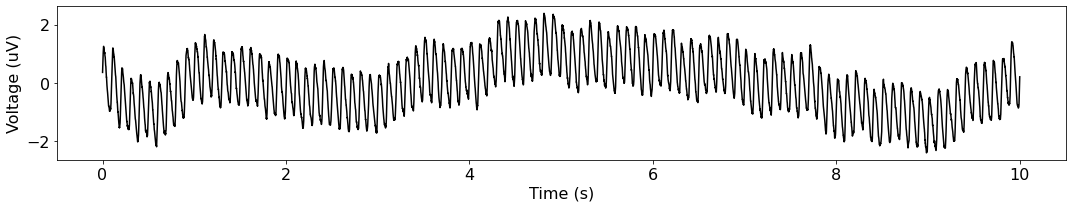

In [4]:
np.random.seed(0)

n_seconds = 10
fs = 1000

components = {'sim_oscillation': {'freq':10, 'cycle':'asine', 'rdsym': .25},
              'sim_powerlaw': {'exponent': -2}}

sig = sim_combined(n_seconds, fs, components=components)


f_range = (1, 100)

freqs, powers = compute_spectrum(sig, fs, f_range=f_range)

times =  np.arange(0, len(sig)/fs, 1/fs)
plot_time_series(times, sig)

In [3]:
components = {'sim_oscillation': {'freq':20, 'cycle':'asine', 'rdsym': .5},
              'sim_powerlaw': {'exponent': -2}}

_sig = sim_combined(n_seconds, fs, components=components)

sig = np.concatenate((sig, _sig))


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



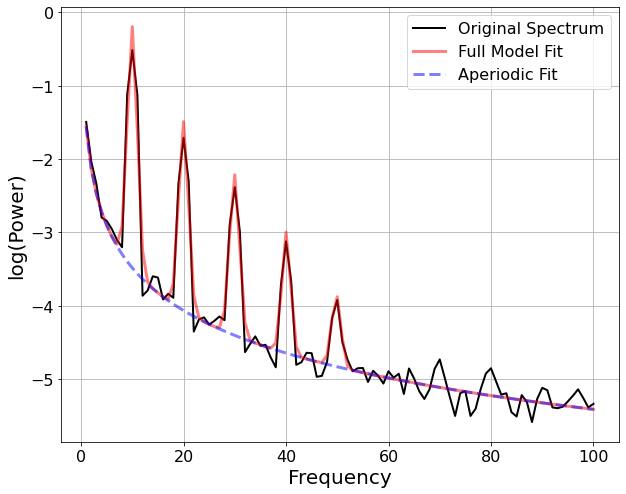

In [5]:
fm = FOOOF()
fm.fit(freqs, powers)
fm.plot()

In [6]:
imf_kwargs = {'sd_thresh': .1, 'energy_thresh': 50}
              
fm_refit, imfs, pe_mask = refit(fm.copy(), sig, fs, f_range,
                                imf_kwargs=imf_kwargs, power_thresh=.6)

# Remove imfs that aren't above 1/f
imfs_filt = imfs[pe_mask]

[0, 0.8249259364663319, 5.095930801728114]
[20.19186160345623, 5.114487599126617, 20.383723206912457]


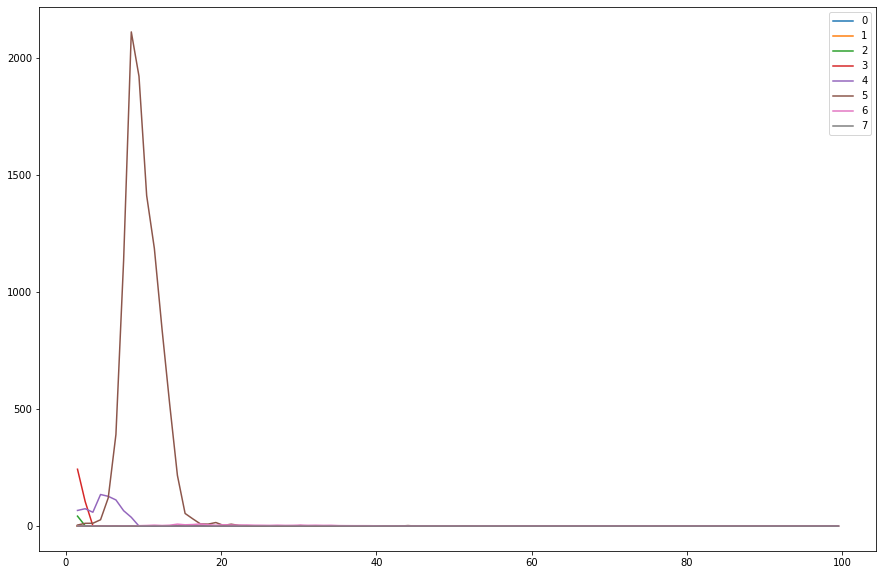

In [7]:
import emd

IP, IF, IA = emd.spectra.frequency_transform(imfs.T, fs, 'nht')

freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 100, 100, 'linear')

# Amplitude weighted HHT
spec_weighted = emd.spectra.hilberthuang_1d(IF, IA, freq_edges)

# Plot
fig = plt.figure(figsize=(15, 10))
for ind, spec in enumerate(spec_weighted.T):
    plt.plot(freq_centres, spec, label=str(ind))

plt.legend()

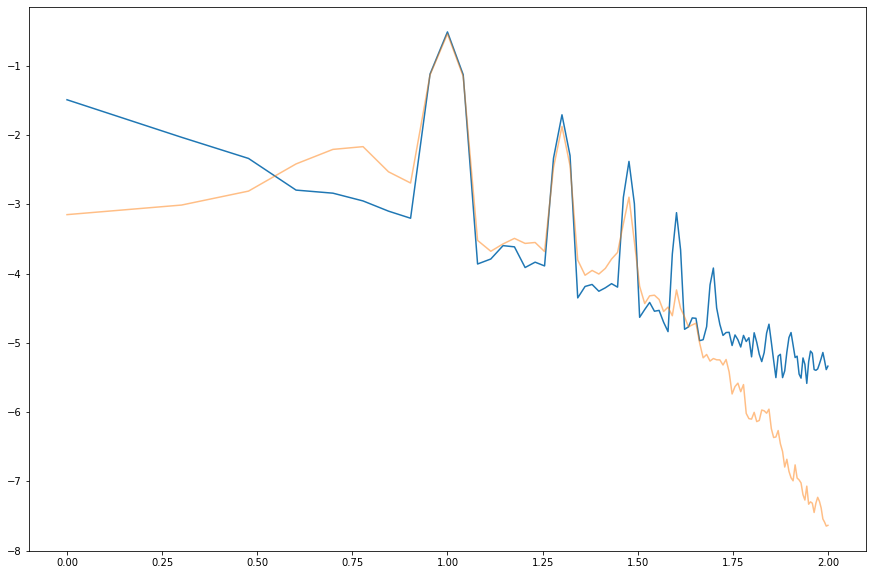

In [8]:
fig = plt.figure(figsize=(15, 10))

plt.plot(np.log10(freqs), np.log10(powers))
    
freqs_imfs, powers_imfs = compute_spectrum(imfs[pe_mask], fs, f_range=f_range)

for p in powers_imfs:
    plt.plot(np.log10(freqs_imfs), np.log10(p), alpha=.5)

In [9]:
motif = Motif(var_thresh=0.1, corr_thresh=0.25, max_clusters=1, random_state=0)
motif.fit(fm_refit, sig, fs)